Household Electricity Consumption Usage Time Series Analysis
---

Author - Ibidokun Ekundayo.  x17156068

This research implements hyper-parameters optimization tuning model OPTUNA to further tune the kernel of the best model CNN-LSTM Encoder-Decoder model and see if we can further improve the results.
---

The data looks contains measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years; the data is initially untidy, and will take a lot of cleaning. 

We will conduct the time series analysis, by applying LSTM AND CNN/LSTM models to predict weekly global active power consumed by the household in the dataset we used. in this notebook.

### Data Description

The dataset is multivariate time series and was collected between December 2006 and November 2010 and observations were collected every minute containing  seven variables (besides the date and time) which are the following:

- global_active_power: The total active power consumed by the household (kilowatts).
- global_reactive_power: The total reactive power consumed by the household (kilowatts).
- voltage: Average voltage (volts).
- global_intensity: Average current intensity (amps).
- sub_metering_1: Active energy for kitchen (watt-hours of active energy).
- sub_metering_2: Active energy for laundry (watt-hours of active energy).
- sub_metering_3: Active energy for climate control systems (watt-hours of active energy).

Active and reactive energy refer to the technical details of alternative current. Information on this dataset can be found at "https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption"

### Import the required libraries

In [1]:
import math
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
from sklearn import preprocessing 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import datetime

sns.set_style('darkgrid')
%matplotlib inline

import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from numpy import nan

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Bidirectional ,Conv1D, Dropout, MaxPooling1D, ConvLSTM2D, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Nadam



In [2]:
def prepare_dataset():
    # Load all data.
    dataset = pd.read_csv('household_power_consumption.txt', sep=';', header=0, low_memory=False, parse_dates={'datetime' : ['Date', 'Time']}, infer_datetime_format=True, index_col=['datetime'])

    # Mark all missing values.
    dataset.replace('?', np.nan, inplace=True)
    # Make dataset numeric.
    dataset = dataset.astype(np.float32)

    # Add a column for for the remainder of sub metering.
    values = dataset.values

    # Save updated dataset
    dataset.to_csv('household_power_consumption.csv')

def resample_dataset():
    # Load the new file
    dataset = pd.read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])

    # Resample minute data to total for each day.
    daily_groups = dataset.resample('D')
    daily_data = daily_groups.sum()

    # summarize.
    print(daily_data.shape)

    # Save.
    daily_data.to_csv('household_power_consumption_days.csv')
    ## Changing the data types to correct format
    daily_data['Global_active_power'] = pd.to_numeric(daily_data['Global_active_power'])
    daily_data['Global_reactive_power'] = pd.to_numeric(daily_data['Global_reactive_power'])
    daily_data['Voltage'] = pd.to_numeric(daily_data['Voltage'])
    daily_data['Global_intensity'] = pd.to_numeric(daily_data['Global_intensity'])
    daily_data['Sub_metering_1'] = pd.to_numeric(daily_data['Sub_metering_1'])
    daily_data['Sub_metering_2'] = pd.to_numeric(daily_data['Sub_metering_2'])
    daily_data['Sub_metering_3'] = pd.to_numeric(daily_data['Sub_metering_3'])

    daily_data.replace('?', nan, inplace=True)

    for j in range(0,7):        
        daily_data.iloc[:,j]=daily_data.iloc[:,j].fillna(daily_data.iloc[:,j].mean())
    daily_data.isnull().sum()
    print(daily_data.info())

    return daily_data

# Split a univariate dataset into train/test sets.
def split_dataset(data):
    # Split into standard weeks.
    train, test = data[1:-328], data[-328:-6]
    # Restructure into windows of weekly data.
    train = np.array(np.split(train, len(train) / 7))
    test = np.array(np.split(test, len(test) / 7))
    print('Train Size : ', train.shape)
    print('Test Size : ', test.shape)
    
    return train, test

In [3]:
prepare_dataset()

### Add a new column (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) = sub_metering_4
 The new column represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. For instance mobile phones, and other gadgets not rated within the kitchen, laundry and climate control systems in the household.  


In [4]:
daily_data = resample_dataset()
daily_data['sub_metering_4'] = (daily_data.iloc[:,0] * 1000 / 60) - (daily_data.iloc[:,4] + daily_data.iloc[:,5] + daily_data.iloc[:,6])
daily_data.head()

(1442, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Global_active_power    1442 non-null   float64
 1   Global_reactive_power  1442 non-null   float64
 2   Voltage                1442 non-null   float64
 3   Global_intensity       1442 non-null   float64
 4   Sub_metering_1         1442 non-null   float64
 5   Sub_metering_2         1442 non-null   float64
 6   Sub_metering_3         1442 non-null   float64
dtypes: float64(7)
memory usage: 90.1 KB
None


Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313.0             0.0          2648.0         14063.0   

            sub_metering_4  
datetime                    
2006-12-16    14680.933333  
2006-12-17    36946.666667  
2006-12-18    19028.433333  
2006-12-19    13131.900000  
2006-12-20    20384.800000

### Define helper functions

In [5]:
# Evaluate one or more weekly forecasts against expected values.
def evaluate_forecasts(actual, predicted):
    # Calculate an RMSE score for each day.
    scores = list()
    for i in range(actual.shape[1]):
        # Calculate MSE.
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # Calculate RMSE.
        rmse = math.sqrt(mse)
        # Store.
        scores.append(rmse)

    # Calculate overall RMSE.
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = math.sqrt(s / (actual.shape[0] * actual.shape[1]))

    return score, scores

# Summarize scores.
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# Convert history into inputs and outputs.
def to_supervised(train, n_input, n_out=7):
    # Flatten data.
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time.
    for _ in range(len(data)):
        # Define the end of the input sequence.
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Ensure we have enough data for this instance.
        if out_end < len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # Move along one time step.
        in_start += 1
    return np.array(X), np.array(y)

# Convert history into inputs and outputs
def to_supervised_for_multivariate(train, n_input, n_out=7):
    # Flatten data.
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # Step over the entire history one time step at a time.
    for _ in range(len(data)):
        # Define the end of the input sequence.
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Ensure we have enough data for this instance.
        if out_end < len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # Move along one time step.
        in_start += 1
    return np.array(X), np.array(y)


# Make a forecast.
def forecast(model, history, n_input):
    # Flatten data.
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # Retrieve last observations for input data.
    input_x = data[-n_input:, 0]
    # Reshape into [1, n_input, 1].
    input_x = input_x.reshape((1, len(input_x), 1))

    # Forecast the next week.
    yhat = model.predict(input_x, verbose=0)

    # We only want the vector forecast.
    yhat = yhat[0]
    return yhat

# Evaluate a single model.
def evaluate_model(model, forecast_func, train, test, n_input):

    # History is a list of weekly data.
    history = [x for x in train]

    # Walk-forward validation over each week.
    predictions = list()
    for i in range(len(test)):
        # Predict the week.
        yhat_sequence = forecast_func(model, history, n_input)
        # Store the predictions.
        predictions.append(yhat_sequence)
        # Get real observation and add to history for predicting the next week.
        history.append(test[i, :])

    # Evaluate predictions days for each week.
    predictions = np.array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

def learning_curve(history):
    plt.style.use('seaborn-dark-palette')
    plt.figure(figsize=(17, 7))

    plt.plot(history.history["loss"], label="training")
    plt.plot(history.history["val_loss"], label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss -Mean Squared Error")
    plt.legend()

    plt.show()
    
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
def get_mean_rmse_and_plot_rmse(scores, days):
    print('Mean Test RMSE Score : ', np.round(scores[0],5))
    print('RMSE for each Weekday')
    plt.figure(figsize = (17,6))
    plt.plot(days, scores[1], marker='o', label='LSTM model with univariate input and vector output') 
    plt.show()

### Scale the dataset and Split into train and test

In [6]:
values = daily_data.values
values = values.astype('float32')
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
train, test = split_dataset(scaled)

Train Size :  (159, 7, 8)
Test Size :  (46, 7, 8)


### Define Callbacks 

In [8]:
import datetime
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def callbacks():
    callbacks_list = []
    log_dir="logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    callbacks_list.append(tensorboard_callback)
    w_fn = 'models\\electricity_prediction-1-{}.h5'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
    callbacks_list.append(early_stopping)
    # Change the cooldown to 1, if behances unexpectedly
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=2.5e-5, cooldown=0)
    callbacks_list.append(learning_rate_reduction)
    model_checkpoint = ModelCheckpoint(w_fn, monitor='val_loss', save_best_only=True)
    callbacks_list.append(model_checkpoint)
    return callbacks_list

callbacks_list = callbacks()

## Model 1 

#### LSTM model

LSTM model
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 7)                 119       
Total params: 77,543
Trainable params: 77,543
Non-trainable params: 0
_________________________________________________________________
None
Train on 988 samples, validate on 110 samples
Epoch 1/100
988/988 [==============================] -

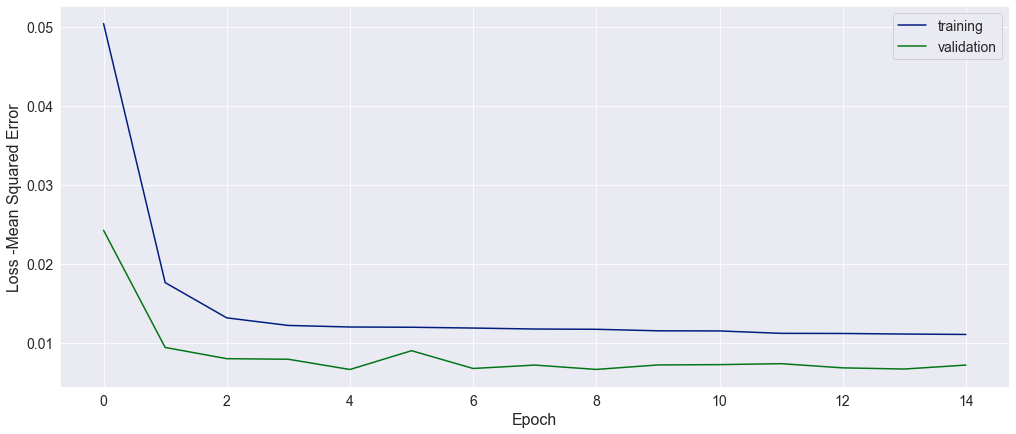

Mean Test RMSE Score :  0.09349
RMSE for each Weekday


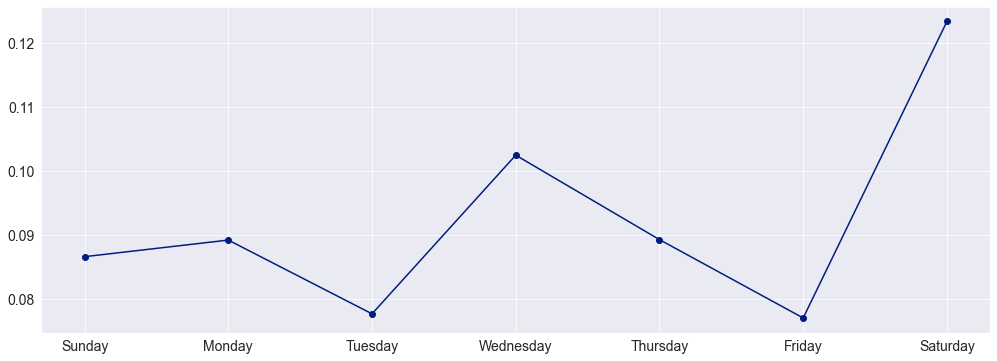

In [25]:
def build_lstm_model(train):

    # Define model.
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    # Fit network.
    return model

print("LSTM model")
print("==========")

n_input = 8
# Prepare data.
train_x, train_y = to_supervised(train, n_input)


# Define parameters.
verbose, epochs, batch_size = 1, 100, 8
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

univariate_LSTM =  build_lstm_model(train, )

history = univariate_LSTM.fit(train_x, train_y, epochs=epochs, validation_split = 0.1, 
                              batch_size=batch_size, verbose=verbose, callbacks = callbacks_list)

learning_curve(history)

scores = evaluate_model(univariate_LSTM, forecast, train, test, 8)
get_mean_rmse_and_plot_rmse(scores, days)

## Model 2

#### Encoder-Decoder LSTM model

Encoder Decoder LSTM model
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 128)               66560     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 64)             49408     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 16)             1040      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 7, 1)              17        
Total params: 117,025
Trainable params: 117,025
Non-trainable params: 0
_________________________________________________________________
None
Train on 988 samples, validate on 110 samples
Epoch 1/100
988/988 [===============

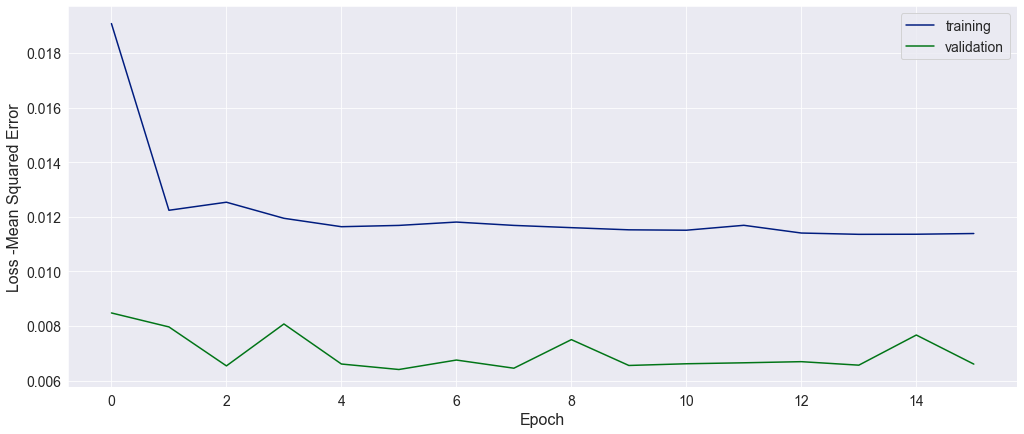

Mean Test RMSE Score :  0.09637
RMSE for each Weekday


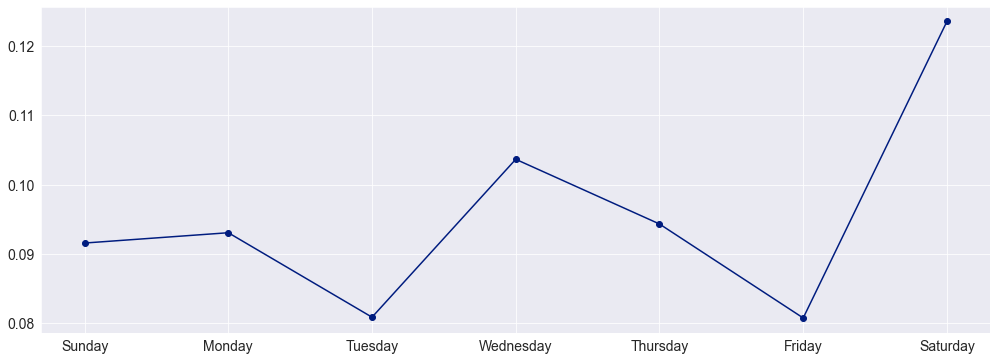

In [27]:
def build_encdec_lstm_model(train):
   # Define model.
    model = Sequential()
    model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(64, return_sequences=True))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model


print("==========================")
print("Encoder Decoder LSTM model")
print("==========================")

univariate_encdec_LSTM =  build_encdec_lstm_model(train)

history = univariate_encdec_LSTM.fit(train_x, train_y, epochs=epochs, validation_split = 0.1, 
                                     batch_size=batch_size, verbose=verbose, callbacks = callbacks_list)

learning_curve(history)

scores = evaluate_model(univariate_encdec_LSTM, forecast, train, test, 8)
get_mean_rmse_and_plot_rmse(scores, days)

## Model 3

#### CNN-LSTM Encoder-Decoder model

CNN-LSTM Encoder-Decoder model
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 6, 64)             256       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 4, 64)             12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 7, 200)            263200    
_________________________________________________________________
time_distributed_8 (Tim

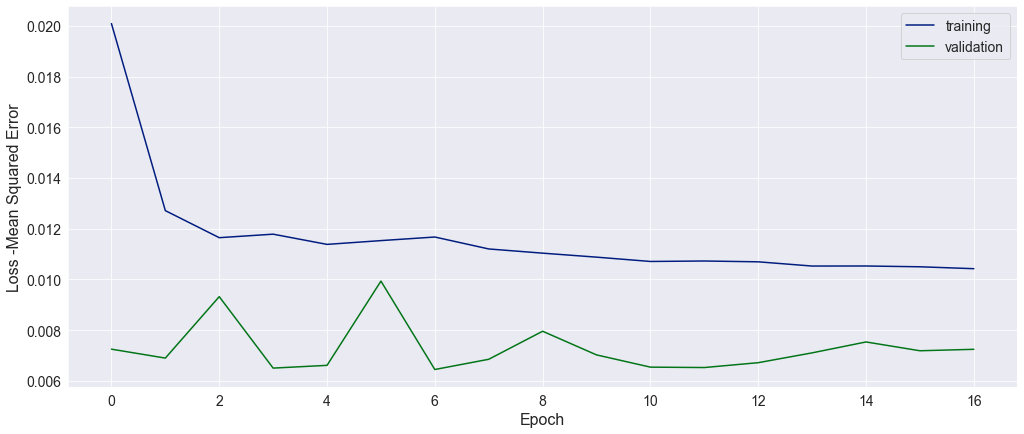

Mean Test RMSE Score :  0.09175
RMSE for each Weekday


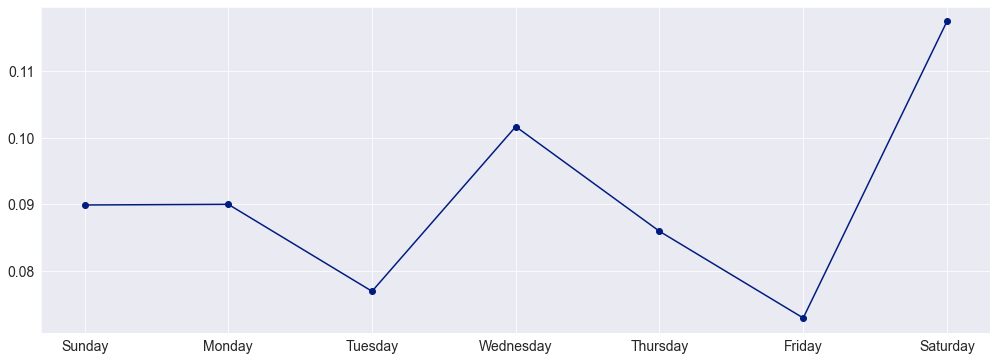

In [30]:
def build_encdec_cnn_lstm_model(train):
    # Define model.
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model


# Prepare data.
train_x, train_y = to_supervised(train, n_input)
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# Reshape output into [samples, timesteps, features].
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

print("CNN-LSTM Encoder-Decoder model")
print("==============================")

univariate_encdec_CNN_LSTM =  build_encdec_cnn_lstm_model(train)

history = univariate_encdec_CNN_LSTM.fit(train_x, train_y, epochs=epochs, validation_split = 0.1, 
                                         batch_size=batch_size, verbose=verbose, callbacks = callbacks_list)

learning_curve(history)

scores = evaluate_model(univariate_encdec_CNN_LSTM, forecast, train, test, 8)
get_mean_rmse_and_plot_rmse(scores, days)

## Model 4

### CNN-Bidirectional LSTM

CNN-LSTM Bi-Directional Model.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 6, 64)             256       
_________________________________________________________________
bidirectional (Bidirectional (None, 6, 256)            197632    
_________________________________________________________________
dropout (Dropout)            (None, 6, 256)            0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 4, 64)             49216     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 4, 512)            657408    
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 512)            0         
_________________________________________________________________
bidirectional_2 (Bidire

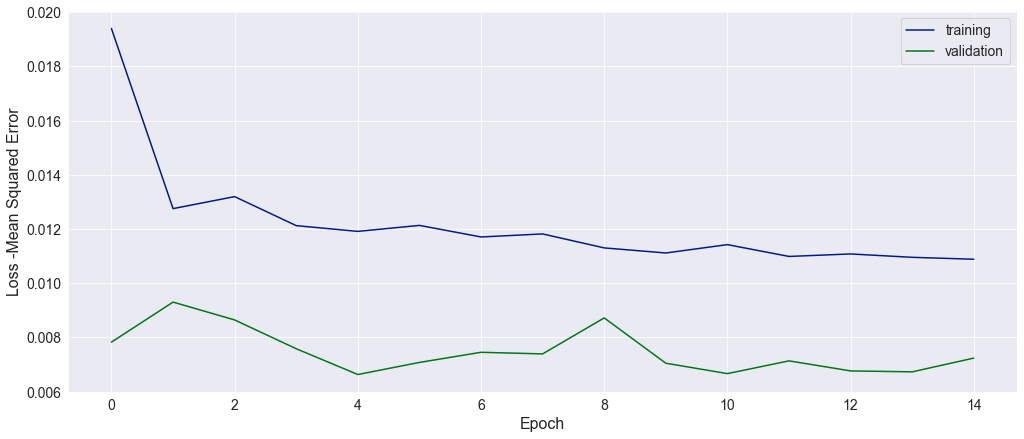

Mean Test RMSE Score :  0.09258
RMSE for each Weekday


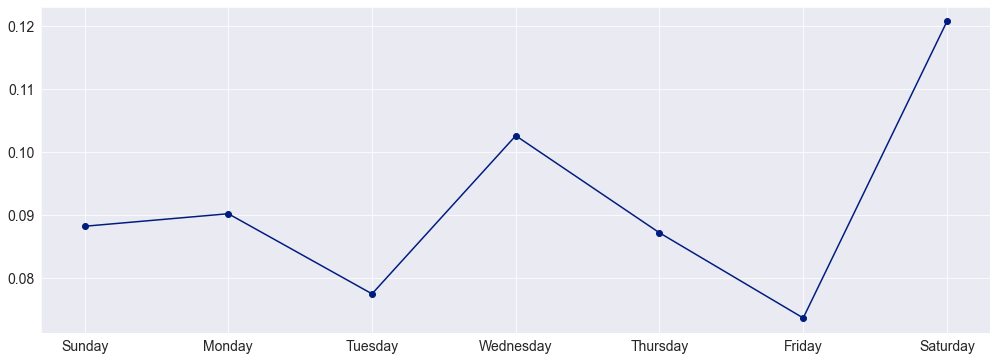

In [31]:
def BiDirectioanl_CNN_LSTM():
    
    # Define model.
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Bidirectional(LSTM(128, input_shape=(n_timesteps,n_features),activation='relu', return_sequences = True)))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Bidirectional(LSTM(256, input_shape=(n_timesteps,n_features),activation='relu', return_sequences = True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(256, input_shape=(n_timesteps,n_features),activation='relu', return_sequences = True)))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation='tanh'))
    model.add(Flatten())
    model.add(Dense(7,activation='linear'))          
    model.compile(loss='mse', optimizer='adam')
    print(model.summary())
    return model

# Prepare data.
train_x, train_y = to_supervised(train, n_input)
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# Reshape output into [samples, timesteps, features].
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1]))

print("CNN-LSTM Bi-Directional Model.")
print("==============================")

BiDirectioanl_CNN_LSTM =  BiDirectioanl_CNN_LSTM()

history = BiDirectioanl_CNN_LSTM.fit(train_x, train_y, epochs=epochs, validation_split = 0.1, 
                                     batch_size=batch_size, verbose=verbose, callbacks = callbacks_list)

learning_curve(history)
scores = evaluate_model(BiDirectioanl_CNN_LSTM, forecast, train, test, 8)
get_mean_rmse_and_plot_rmse(scores, days)

CNN LSTM Encoder-Decoder model seems to be performing the best.. with average RMSe of 0.091 as compared to the other models.

## Hyper Parameter tuning Using Optuna 

There are a few reasons why I am using Optuna:
- It’s possible to specify how long the optimization process should last
- Integration with Pandas DataFrame
- The algorithm uses pruning to discard low-quality trials early
- It’s a relatively new project, and developers continue to work on it
- It was easier to use than Hyperopt (at least for me)

### Define Hyper Parameters

### CNN

|Parameter Name |Description|
|--|-------------------------------|
|filters |	Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).|
|kernel_size |	An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.|
|strides |	An integer or tuple/list of a single integer, specifying the stride length of the convolution. Specifying any |stride | Stride is the number of pixels shifts over the input matrix. When the stride is 1 then we move the filters to 1 pixel at a time. When the stride is 2 then we move the filters to 2 pixels at a time and so on.|
|padding |	Padding is simply a process of adding layers of zeros to our input|
|activation	| Activation function to use. If you don't specify anything, no activation is applied |
|kernel_initializer|	Initializer for the kernel weights matrix ( see keras.initializers).|
|bias_initializer	|Initializer for the bias vector ( see keras.initializers).|
|kernel_regularizer	|Regularizer function applied to the kernel weights matrix (see keras.regularizers).|
|bias_regularizer	|Regularizer function applied to the bias vector ( see keras.regularizers).|


### LSTM

|Parameter Name |Description|
|--|-------------------------------|
|units|  Positive integer, dimensionality of the output space.|
|activation|  Activation function to use. Default|  hyperbolic tangent (tanh). If you pass None, no activation is applied (ie. "linear" activation|  a(x) = x).|
|recurrent_activation|  Activation function to use for the recurrent step. Default|  sigmoid (sigmoid). If you pass None, no activation is applied (ie. "linear" activation|  a(x) = x).|
|use_bias|  Boolean (default True), whether the layer uses a bias vector.|
|kernel_initializer|  Initializer for the kernel weights matrix, used for the linear transformation of the inputs. Default|  glorot_uniform.|
|recurrent_initializer|  Initializer for the recurrent_kernel weights matrix, used for the linear transformation of the |recurrent state. Default|  orthogonal.|
|bias_initializer|  Initializer for the bias vector. Default|  zeros.|
|kernel_regularizer|  Regularizer function applied to the kernel weights matrix. Default|  None.|

#### Other Parameters to tune

* Batch Size - Number of Samples for each iteration
* Epoch  -Number of Iterations

We use the following Stochastic Based Gradient Descent Optimizer.
1. SGD
2. ADAM
2. RMSPROP

For each of the optimiser, we will also tune the learning rate.

To aovid Overfitting of the model, we need to use regarization methods.
1. Kernel based Regularization (Lasso and Ridge)
2. Dropout
3. Data Scaling

In [ ]:
params = {
 "optuna": {"name": "HECStudy2", "direction": "minimize", "db": "SQLite",  "metric": "mean_squared_error", "model" : "Encoder_Dec_CNN-LSTM"},
 "hparams": {
    "hp_filters"  : {"dtype": "int", "sampler": "categorical", "values": [32, 64, 128]},
    "hp_kernel_size" : {"dtype": "int", "sampler": "categorical", "values": [2]}, 
    "hp_strides" : {"dtype": "int", "sampler": "categorical", "values": [1, 2]}, 
    "hp_activation" : {"dtype": "string", "sampler": "categorical", "values": ["relu", "linear", "elu", "selu"]}, 
     
    "pool_size" : {"dtype": "int", "sampler": "categorical", "values": [1,2]}, 
     
    "lstm_units" : {"dtype": "int", "sampler": "categorical", "values": [32, 64]}, 
     
    "kernel_regularizer" : {"dtype": "string", "sampler": "categorical", "values": ["l1", "l2"]} , 
    "kernel_initializer" : {"dtype": "string", "sampler": "categorical", "values": ["glorot_normal", "glorot_uniform"]} , 
    
     
    "optimizer" : {"dtype": "string", "sampler": "categorical", "values": ["sgd", "adam", "rmsprop"]} , 
    "hp_lrmin" : {"dtype": "int", "sampler": "categorical", "values": 1e-3}, 
    "hp_lrmax" : {"dtype": "int", "sampler": "categorical", "values": 1e-1}, 
    "epochs": {"dtype": "int", "sampler": "categorical", "values": 100} , 
    "batch_size": {"dtype": "int", "sampler": "categorical", "values": 8}}
}

In [10]:
optuna_args_dict = params['optuna']
hps_dict = params['hparams']

In [11]:
pd.DataFrame(hps_dict).T

dtype      sampler                           values
hp_filters             int  categorical                    [32, 64, 128]
hp_kernel_size         int  categorical                              [2]
hp_strides             int  categorical                           [1, 2]
hp_activation       string  categorical        [relu, linear, elu, selu]
pool_size              int  categorical                           [1, 2]
lstm_units             int  categorical                         [32, 64]
kernel_regularizer  string  categorical                         [l1, l2]
kernel_initializer  string  categorical  [glorot_normal, glorot_uniform]
optimizer           string  categorical             [sgd, adam, rmsprop]
hp_lrmin               int  categorical                            0.001
hp_lrmax               int  categorical                              0.1
epochs                 int  categorical                              100
batch_size             int  categorical                                8

In [12]:
pd.Series(optuna_args_dict).T

name                    HECStudy2
direction                minimize
db                         SQLite
metric         mean_squared_error
model        Encoder_Dec_CNN-LSTM
dtype: object

### Define the model Architecture

In [13]:
def optuna_model(hps_dict, trial):
    # Sequential Layer
    model = Sequential()
    # Covolutional Layer
    model.add(
        Conv1D(
                filters=trial.suggest_categorical("filters", hps_dict['hp_filters']['values']),
                kernel_size=trial.suggest_categorical("kernel_size", hps_dict['hp_kernel_size']['values']),
                strides=trial.suggest_categorical("strides", hps_dict['hp_strides']['values']),
                activation=trial.suggest_categorical("activation", hps_dict['hp_activation']['values']),
                input_shape = (n_timesteps,n_features)
            )
    )
    model.add(
        Conv1D(
                filters=trial.suggest_categorical("filters", hps_dict['hp_filters']['values']),
                kernel_size=trial.suggest_categorical("kernel_size", hps_dict['hp_kernel_size']['values']),
                strides=trial.suggest_categorical("strides", hps_dict['hp_strides']['values']),
                activation=trial.suggest_categorical("activation", hps_dict['hp_activation']['values']),
                input_shape = (n_timesteps,n_features)
            )
    )    
    # Pooling Layer
    model.add(MaxPooling1D(trial.suggest_categorical("pool_size", hps_dict['pool_size']['values'])))
    model.add(Dropout(0.3))
    # Flatter the layer to use fully conected layers
    model.add(Flatten())    
    model.add(RepeatVector(n_outputs))
        
        
    model.add(
        LSTM(
            units =trial.suggest_categorical("lstm_units", hps_dict['lstm_units']['values']),
            activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(1, activation='linear')))
    # Compile model with a sampled learning rate.
    optimizer = trial.suggest_categorical("optimizer", hps_dict['optimizer']['values'])
    learning_rate = trial.suggest_float("learning_rate", hps_dict['hp_lrin']['values'], hps_dict['hp_lrmax']['values'])

    if optimizer == "sgd":
        opt = SGD(learning_rate)
    elif optimizer == "adam":
        opt = Adam(learning_rate)
    elif optimizer == "rmsprop":
        opt = RMSprop(learning_rate)
    
    model.compile(
        loss="mse", optimizer=opt, metrics=[optuna_args_dict['metric']]
    )

    print(model.summary())

    return model

## Define Learning Curve for model and Evaluation for Optuna Study

In [14]:
def model_learning_curve(history):
    """
    This function plots a training and testing loss
    """
    
    # Loss with Epoch
    plt.figure('16,6')
    plt.title('Model Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    
def show_results(study):
    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    
    # Show results from Optuna results

    pruned_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.structs.TrialState.COMPLETE]

    print('Study statistics: ')
    print('  Number of finished trials: ', len(study.trials))
    print('  Number of pruned trials: ', len(pruned_trials))
    print('  Number of complete trials: ', len(complete_trials))

    print('Best trial:')
    trial = study.best_trial

    print('  Value: ', trial.value)

    print('  Params: ')
    for key, value in trial.params.items():
        print('    {}: {}'.format(key, value))
    return study


### Define Experiment Manager for Optuna Hyper Parameter Study

#### Pruning

Pruning feature automatically stops unpromising trials at the early stages of the training (a.k.a., automated early-stopping). Optuna provides interfaces to concisely implement the pruning mechanism in iterative training algorithms.

In [15]:
from optuna.integration import KerasPruningCallback


Using TensorFlow backend.


## Next, in class Objective(object), we add a new callback to the callbacks list:

In [16]:
class ExperimentManager(object):
    def __init__(self, optuna_args_dict, hps_dict, train_x, train_y, test_x, test_y, callbacks_list):
        
        self.optuna_args_dict = optuna_args_dict
        self.hps_dict = hps_dict
        self.callbacks_list = callbacks_list
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        
    def __call__(self, trial):
        
        verbose = 1
        n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

        # Sequential Layer
        model = Sequential()
        # Covolutional Layer
        model.add(
            Conv1D(
                    filters=trial.suggest_categorical("filters", hps_dict['hp_filters']['values']),
                    kernel_size=trial.suggest_categorical("kernel_size", hps_dict['hp_kernel_size']['values']),
                    strides=trial.suggest_categorical("strides", hps_dict['hp_strides']['values']),
                    activation=trial.suggest_categorical("activation", hps_dict['hp_activation']['values']),
                    input_shape = (n_timesteps,n_features),
                    kernel_initializer = trial.suggest_categorical("kernel_initializer", hps_dict['kernel_initializer']['values']),
                    kernel_regularizer = trial.suggest_categorical("kernel_regularizer", hps_dict['kernel_regularizer']['values'])
                )
        )
        model.add(
            Conv1D(
                    filters=trial.suggest_categorical("filters", hps_dict['hp_filters']['values']),
                    kernel_size=trial.suggest_categorical("kernel_size", hps_dict['hp_kernel_size']['values']),
                    strides=trial.suggest_categorical("strides", hps_dict['hp_strides']['values']),
                    activation=trial.suggest_categorical("activation", hps_dict['hp_activation']['values']),
                    input_shape = (n_timesteps,n_features),
                    kernel_initializer = trial.suggest_categorical("kernel_initializer", hps_dict['kernel_initializer']['values']),
                    kernel_regularizer = trial.suggest_categorical("kernel_regularizer", hps_dict['kernel_regularizer']['values'])

                )
        )    
        # Pooling Layer
        model.add(MaxPooling1D(trial.suggest_categorical("pool_size", hps_dict['pool_size']['values'])))
        # Flatter the layer to use fully conected layers
        model.add(Flatten())    
        model.add(RepeatVector(n_outputs))
        
        
        model.add(
            LSTM(
                units =trial.suggest_categorical("lstm_units", hps_dict['lstm_units']['values']),
                activation='relu', return_sequences=True))
        model.add(TimeDistributed(Dense(32, activation='relu')))
        model.add(TimeDistributed(Dense(1, activation='linear')))
        # Compile model with a sampled learning rate.
        optimizer = trial.suggest_categorical("optimizer", hps_dict['optimizer']['values'])
        learning_rate = trial.suggest_float("learning_rate", hps_dict['hp_lrmin']['values'], hps_dict['hp_lrmax']['values'])

        if optimizer == "sgd":
            opt = SGD(learning_rate)
        elif optimizer == "adam":
            opt = Adam(learning_rate)
        elif optimizer == "rmsprop":
            opt = RMSprop(learning_rate)
    
        model.compile(
            loss="mse", optimizer=opt, metrics=[optuna_args_dict['metric']]
        )

        print(model.summary())
        ### Adding Keras Pruning for Optuna
        #callbacks_list.append(KerasPruningCallback(trial, 'val_loss'))

        history = model.fit(
                train_x,
                train_y,
                validation_data=(test_x, test_y),
                shuffle=True,
                batch_size=hps_dict['batch_size']['values'],
                epochs=hps_dict['epochs']['values'],
                verbose=2,
                callbacks=callbacks_list
        )

        # Evaluate the model accuracy on the test set.
        score = model.evaluate(test_x, test_y, verbose=2)
        #### Calculating Accuracy
        mse_score = score[1] 
        #### showing Evaluation
        model_learning_curve(history)
        
        return mse_score

In [17]:
# import Optuna and OptKeras after Keras
import optuna 
print('Optuna', optuna.__version__)
from optuna.integration import TFKerasPruningCallback
from optkeras.optkeras import OptKeras
import optkeras
print('OptKeras', optkeras.__version__)
# (Optional) Disable messages from Optuna below WARN level.
optuna.logging.set_verbosity(optuna.logging.WARN)

import sqlite3
con = sqlite3.connect(optuna_args_dict['name'] + '_Optuna.db')

Optuna 1.5.0


[W 2020-08-05 16:36:29,693] `structs` is deprecated. Classes have moved to the following modules. `structs.StudyDirection`->`study.StudyDirection`, `structs.StudySummary`->`study.StudySummary`, `structs.FrozenTrial`->`trial.FrozenTrial`, `structs.TrialState`->`trial.TrialState`, `structs.TrialPruned`->`exceptions.TrialPruned`.


OptKeras 0.0.7


Preparing Data
Train Size :  (159, 7, 8)
Test Size :  (46, 7, 8)
Tuning Model with Optuna
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4, 128)            384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 7, 256)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 64)             82176     
________________________________

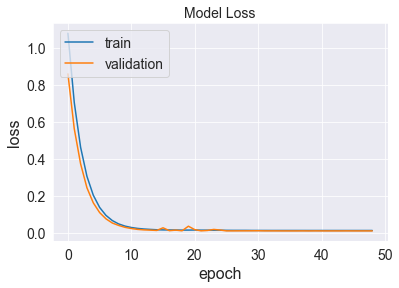

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 4, 128)            384       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 64)             49408     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 7, 32)            

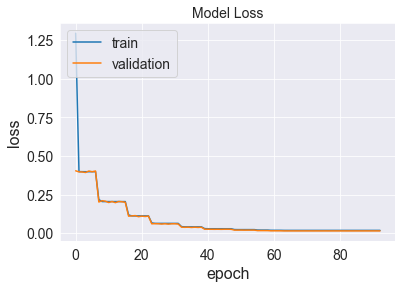

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 7, 64)             192       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 6, 64)             8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 192)               0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 7, 192)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 32)             28800     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 7, 32)            

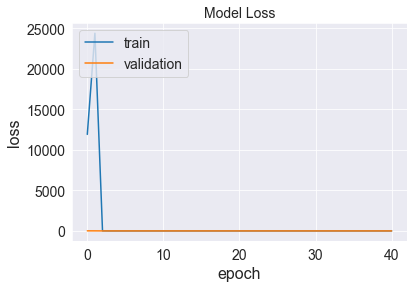

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 4, 64)             192       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2, 64)             8256      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 7, 128)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 7, 32)             20608     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 7, 32)            

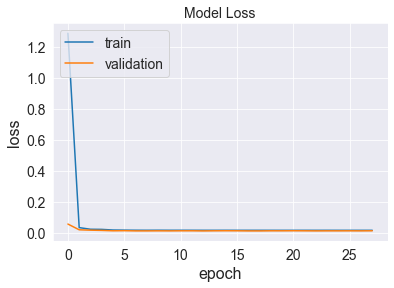

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 4, 32)             96        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 2, 32)             2080      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1, 32)             0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)                0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 7, 32)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 32)             8320      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 7, 32)            

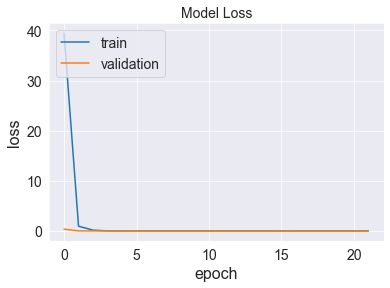

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 2, 32)             2080      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 64)                0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 7, 64)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 64)             33024     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 7, 32)            

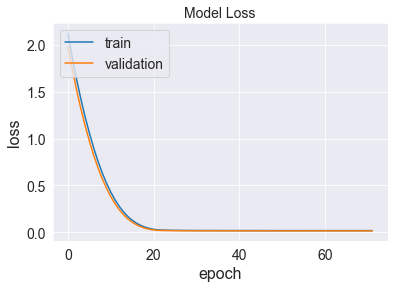

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 7, 32)             96        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 6, 32)             2080      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 192)               0         
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 7, 192)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 7, 64)             65792     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 7, 32)            

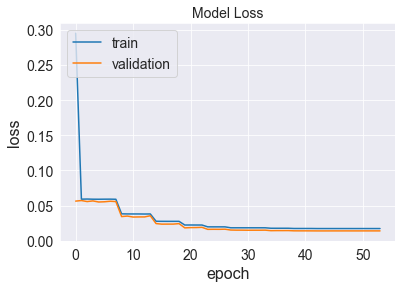

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 7, 64)             192       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 6, 64)             8256      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 384)               0         
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 7, 384)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 7, 64)             114944    
_________________________________________________________________
time_distributed_14 (TimeDis (None, 7, 32)            

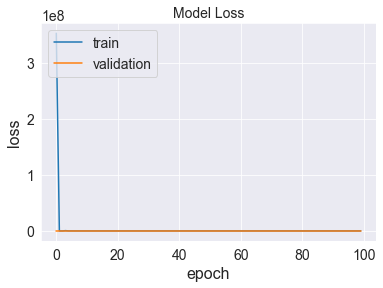

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 2, 32)             2080      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 2, 32)             0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 7, 64)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 7, 64)             33024     
_________________________________________________________________
time_distributed_16 (TimeDis (None, 7, 32)            

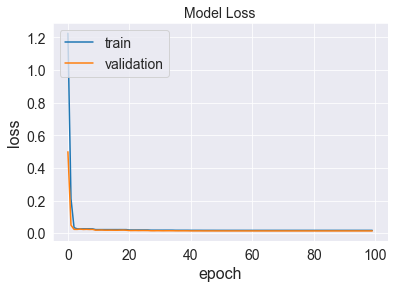

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 7, 64)             192       
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 6, 64)             8256      
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 192)               0         
_________________________________________________________________
repeat_vector_9 (RepeatVecto (None, 7, 192)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 7, 32)             28800     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 7, 32)            

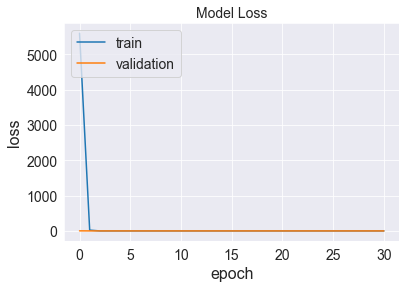

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_20 (TimeDis (None, 7, 32)           

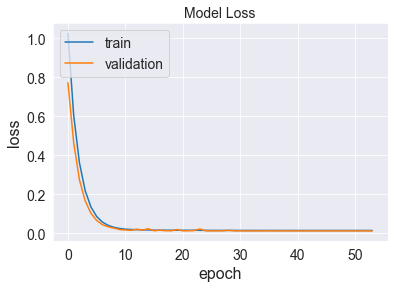

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_11 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 7, 32)           

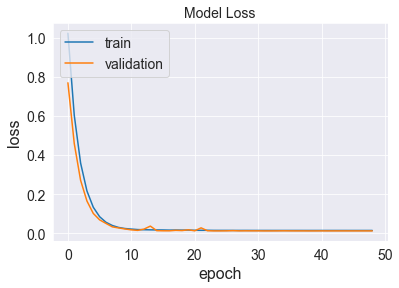

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_12 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_24 (TimeDis (None, 7, 32)           

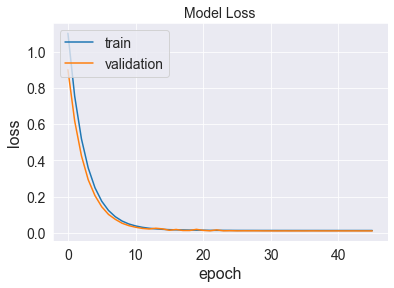

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_26 (TimeDis (None, 7, 32)           

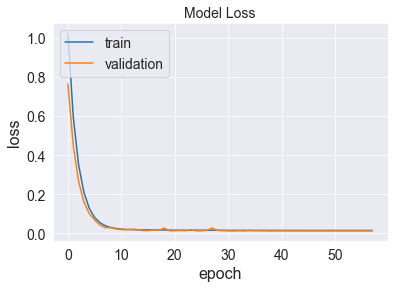

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_28 (TimeDis (None, 7, 32)           

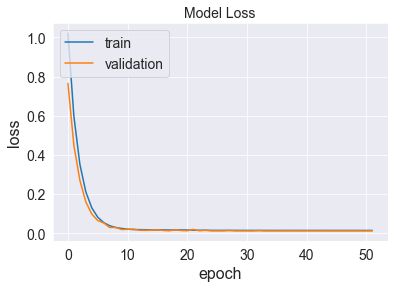

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_30 (TimeDis (None, 7, 32)           

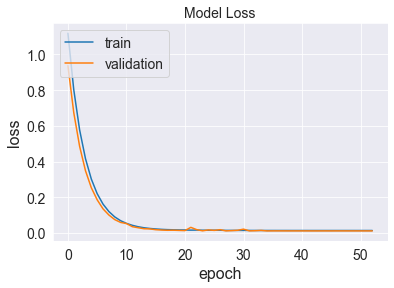

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_32 (TimeDis (None, 7, 32)           

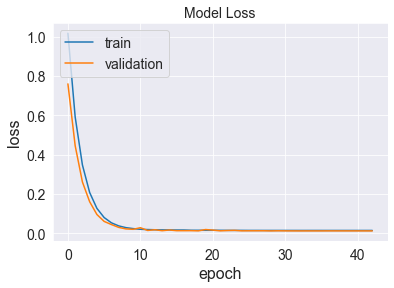

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_17 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_34 (TimeDis (None, 7, 32)           

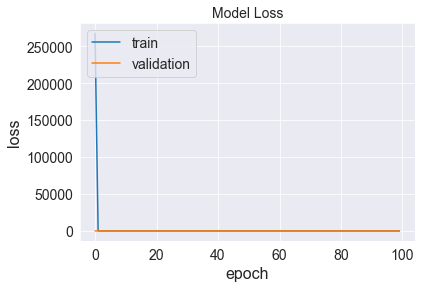

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_36 (TimeDis (None, 7, 32)           

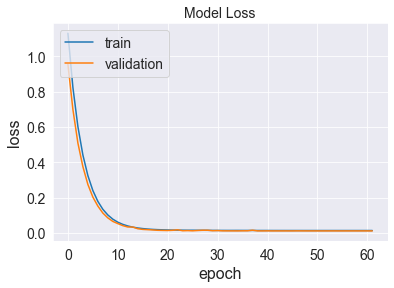

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_19 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_38 (TimeDis (None, 7, 32)           

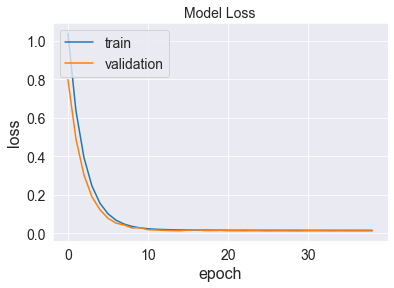

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_20 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_40 (TimeDis (None, 7, 32)           

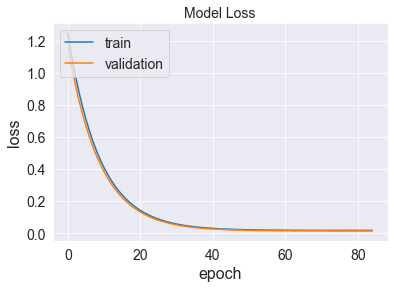

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_21 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_42 (TimeDis (None, 7, 32)           

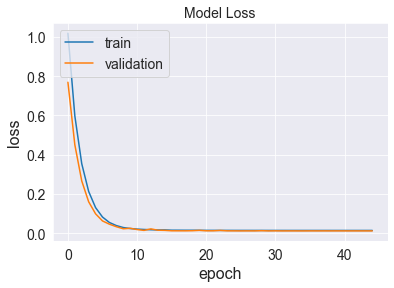

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_22 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_44 (TimeDis (None, 7, 32)           

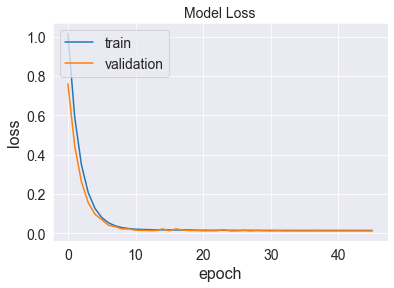

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_46 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_23 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_46 (TimeDis (None, 7, 32)           

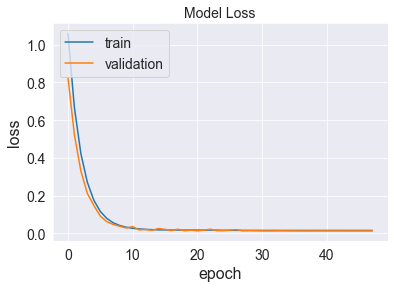

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_24 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_48 (TimeDis (None, 7, 32)           

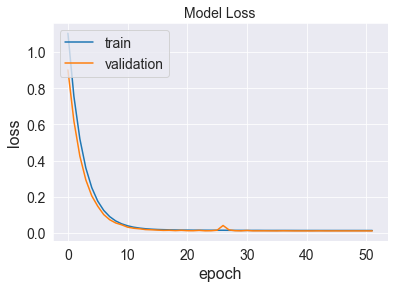

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_50 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_51 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_25 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_50 (TimeDis (None, 7, 32)           

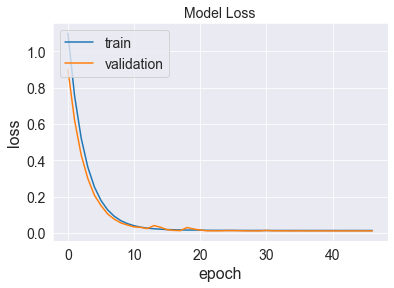

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_52 (Conv1D)           (None, 7, 128)            384       
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 6, 128)            32896     
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 3, 128)            0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 384)               0         
_________________________________________________________________
repeat_vector_26 (RepeatVect (None, 7, 384)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 7, 64)             114944    
_________________________________________________________________
time_distributed_52 (TimeDis (None, 7, 32)           

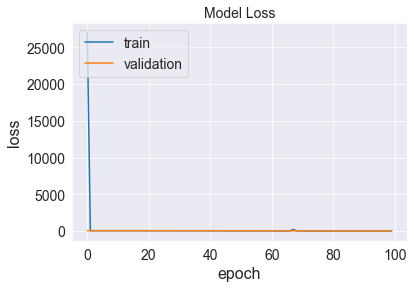

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_27 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_27 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 7, 32)             36992     
_________________________________________________________________
time_distributed_54 (TimeDis (None, 7, 32)           

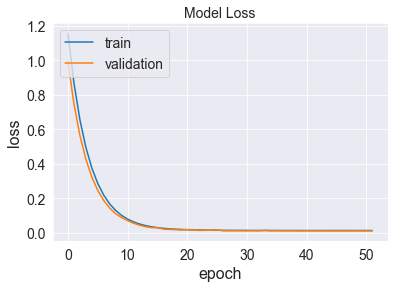

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_28 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_56 (TimeDis (None, 7, 32)           

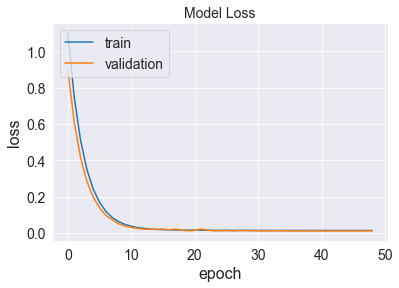

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_58 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_29 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_58 (TimeDis (None, 7, 32)           

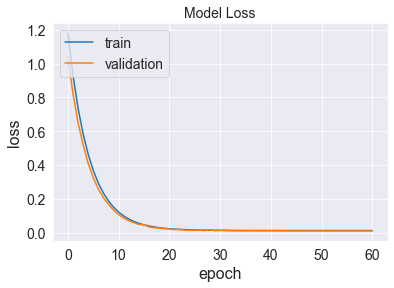

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_30 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_30 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_60 (TimeDis (None, 7, 32)           

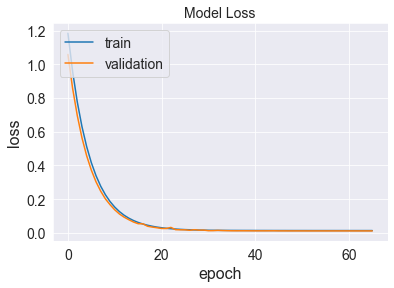

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_63 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_31 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_62 (TimeDis (None, 7, 32)           

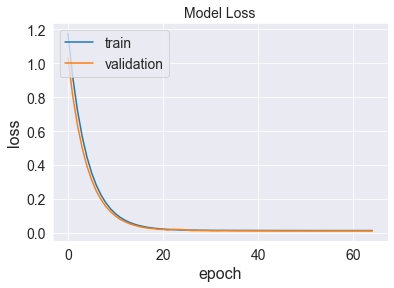

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_32 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_64 (TimeDis (None, 7, 32)           

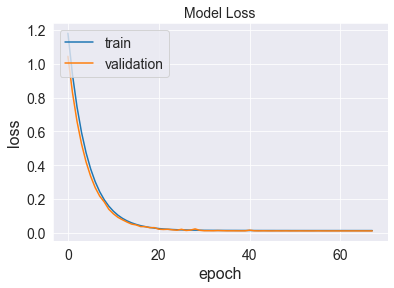

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_33 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_66 (TimeDis (None, 7, 32)           

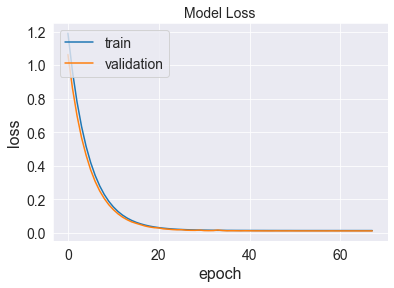

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_68 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 128)               0         
_________________________________________________________________
repeat_vector_34 (RepeatVect (None, 7, 128)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 7, 64)             49408     
_________________________________________________________________
time_distributed_68 (TimeDis (None, 7, 32)           

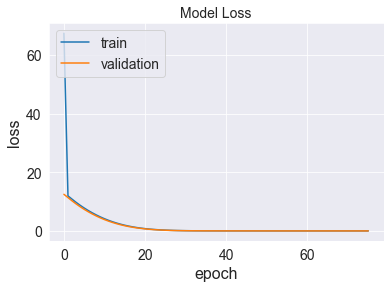

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 4, 64)             192       
_________________________________________________________________
conv1d_71 (Conv1D)           (None, 2, 64)             8256      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 128)               0         
_________________________________________________________________
repeat_vector_35 (RepeatVect (None, 7, 128)            0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 7, 32)             20608     
_________________________________________________________________
time_distributed_70 (TimeDis (None, 7, 32)           

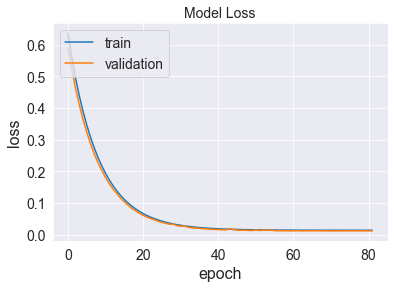

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_36 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_36 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_72 (TimeDis (None, 7, 32)           

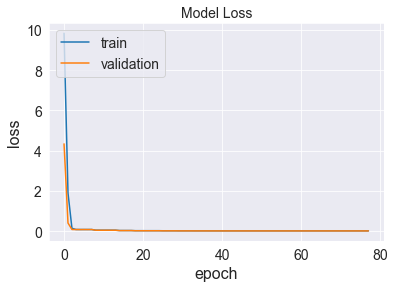

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_74 (Conv1D)           (None, 7, 32)             96        
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 6, 32)             2080      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 3, 32)             0         
_________________________________________________________________
flatten_37 (Flatten)         (None, 96)                0         
_________________________________________________________________
repeat_vector_37 (RepeatVect (None, 7, 96)             0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 7, 64)             41216     
_________________________________________________________________
time_distributed_74 (TimeDis (None, 7, 32)           

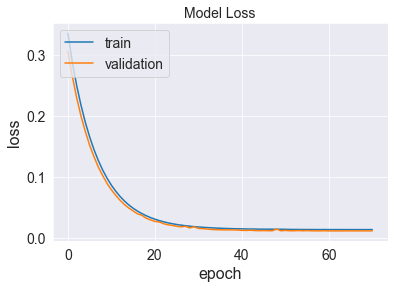

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_76 (Conv1D)           (None, 4, 64)             192       
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 2, 64)             8256      
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 128)               0         
_________________________________________________________________
repeat_vector_38 (RepeatVect (None, 7, 128)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 7, 32)             20608     
_________________________________________________________________
time_distributed_76 (TimeDis (None, 7, 32)           

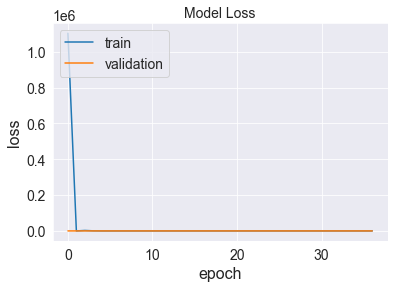

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_78 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_79 (Conv1D)           (None, 2, 32)             2080      
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 2, 32)             0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 64)                0         
_________________________________________________________________
repeat_vector_39 (RepeatVect (None, 7, 64)             0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 7, 64)             33024     
_________________________________________________________________
time_distributed_78 (TimeDis (None, 7, 32)           

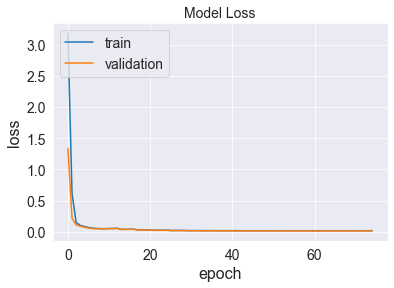

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_40 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_80 (TimeDis (None, 7, 32)           

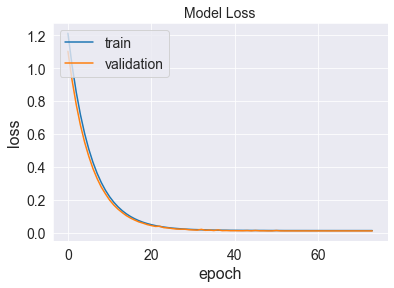

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_82 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_83 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_41 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_82 (TimeDis (None, 7, 32)           

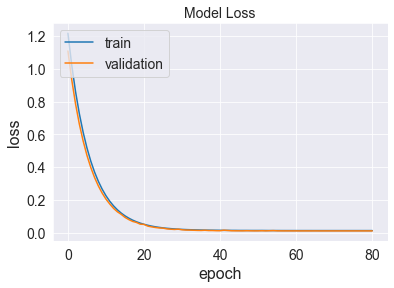

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_84 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_85 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_42 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_42 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_84 (TimeDis (None, 7, 32)           

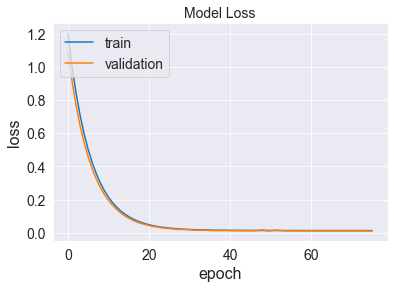

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_86 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_87 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_43 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_86 (TimeDis (None, 7, 32)           

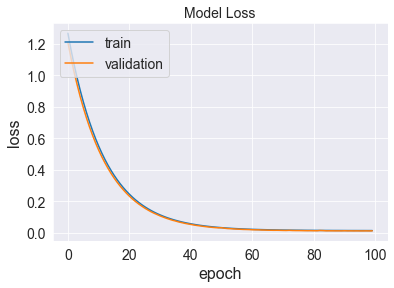

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_88 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_89 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_44 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_88 (TimeDis (None, 7, 32)           

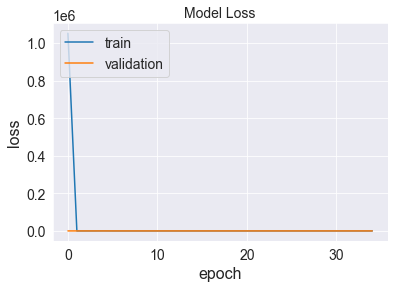

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 7, 128)            384       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 6, 128)            32896     
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 6, 128)            0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 768)               0         
_________________________________________________________________
repeat_vector_45 (RepeatVect (None, 7, 768)            0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 7, 64)             213248    
_________________________________________________________________
time_distributed_90 (TimeDis (None, 7, 32)           

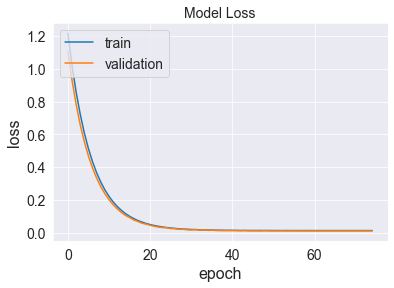

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_92 (Conv1D)           (None, 4, 64)             192       
_________________________________________________________________
conv1d_93 (Conv1D)           (None, 2, 64)             8256      
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 128)               0         
_________________________________________________________________
repeat_vector_46 (RepeatVect (None, 7, 128)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 7, 64)             49408     
_________________________________________________________________
time_distributed_92 (TimeDis (None, 7, 32)           

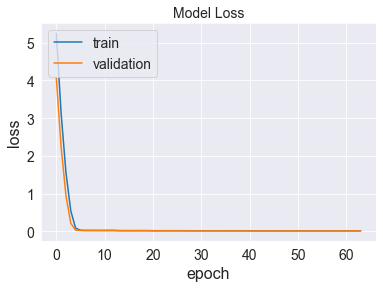

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_94 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_95 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 1, 128)            0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 128)               0         
_________________________________________________________________
repeat_vector_47 (RepeatVect (None, 7, 128)            0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 7, 64)             49408     
_________________________________________________________________
time_distributed_94 (TimeDis (None, 7, 32)           

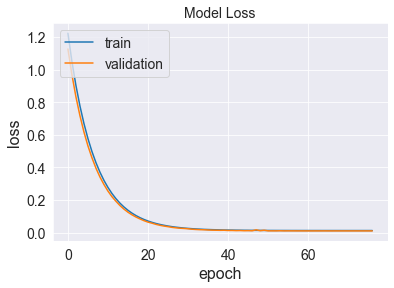

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 4, 32)             96        
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 2, 32)             2080      
_________________________________________________________________
max_pooling1d_48 (MaxPooling (None, 2, 32)             0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 64)                0         
_________________________________________________________________
repeat_vector_48 (RepeatVect (None, 7, 64)             0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 7, 32)             12416     
_________________________________________________________________
time_distributed_96 (TimeDis (None, 7, 32)           

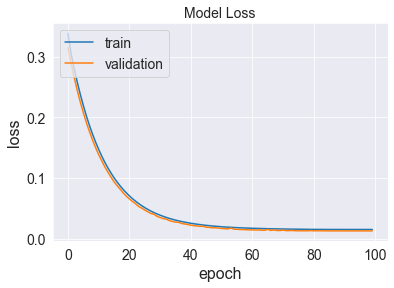

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_98 (Conv1D)           (None, 4, 128)            384       
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_49 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_98 (TimeDis (None, 7, 32)           

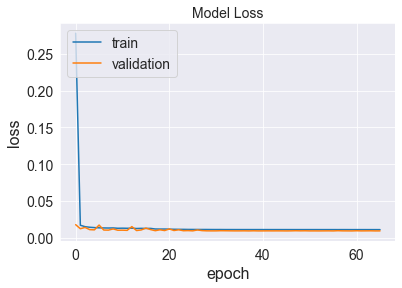

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_100 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_101 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_50 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_100 (TimeDi (None, 7, 32)           

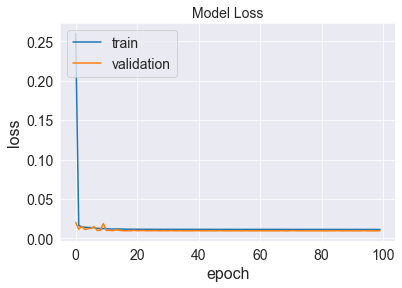

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_102 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_51 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_102 (TimeDi (None, 7, 32)           

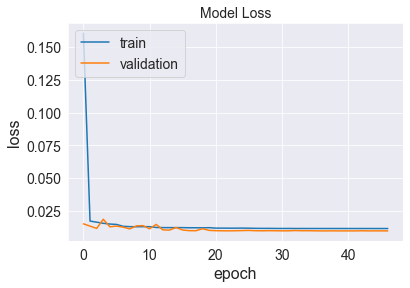

Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_104 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_105 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_52 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_52 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_104 (TimeDi (None, 7, 32)           

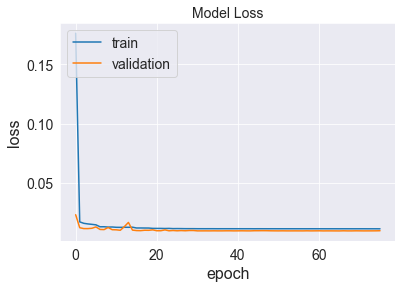

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_106 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_53 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_53 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_53 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_106 (TimeDi (None, 7, 32)           

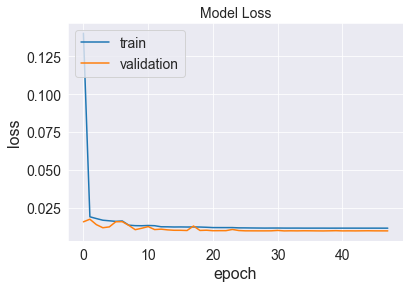

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_108 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_54 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_54 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_54 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_108 (TimeDi (None, 7, 32)           

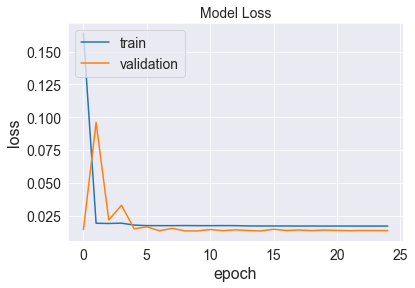

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_110 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_111 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_55 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_55 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_55 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_110 (TimeDi (None, 7, 32)           

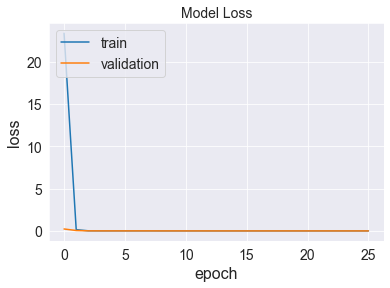

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_112 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_113 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_56 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_56 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_56 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_112 (TimeDi (None, 7, 32)           

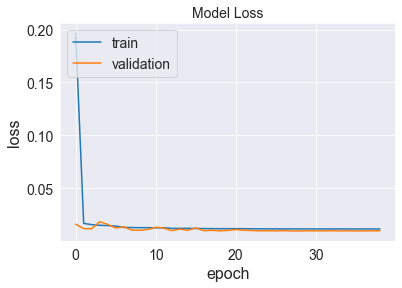

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_114 (Conv1D)          (None, 7, 128)            384       
_________________________________________________________________
conv1d_115 (Conv1D)          (None, 6, 128)            32896     
_________________________________________________________________
max_pooling1d_57 (MaxPooling (None, 6, 128)            0         
_________________________________________________________________
flatten_57 (Flatten)         (None, 768)               0         
_________________________________________________________________
repeat_vector_57 (RepeatVect (None, 7, 768)            0         
_________________________________________________________________
lstm_57 (LSTM)               (None, 7, 64)             213248    
_________________________________________________________________
time_distributed_114 (TimeDi (None, 7, 32)           

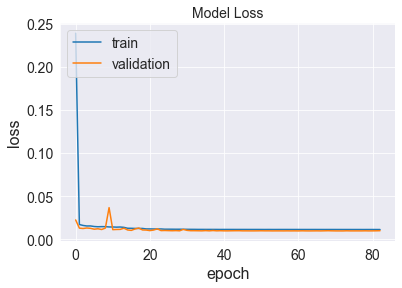

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_116 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_117 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_58 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_58 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_58 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_116 (TimeDi (None, 7, 32)           

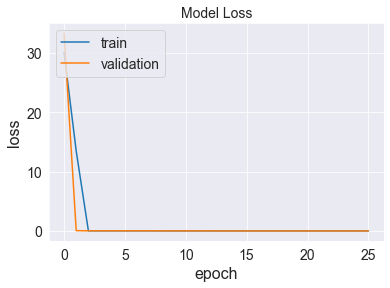

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_118 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_119 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_59 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_59 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_59 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_118 (TimeDi (None, 7, 32)           

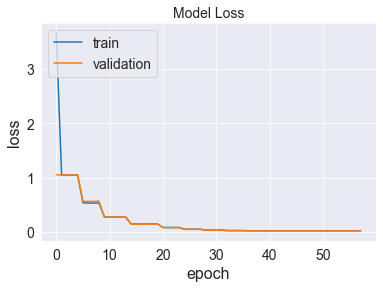

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_60 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_60 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_60 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_120 (TimeDi (None, 7, 32)           

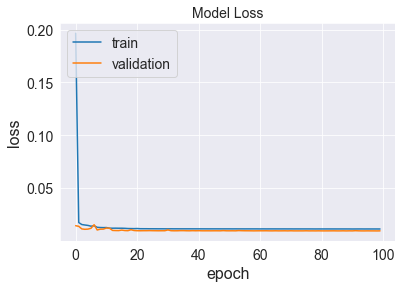

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_122 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_61 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_61 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_122 (TimeDi (None, 7, 32)           

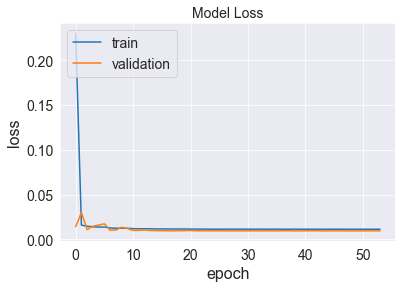

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_124 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_125 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_62 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_62 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_62 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_124 (TimeDi (None, 7, 32)           

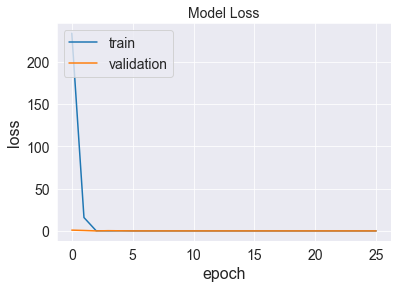

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_126 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_127 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_63 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_63 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_63 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_63 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_126 (TimeDi (None, 7, 32)           

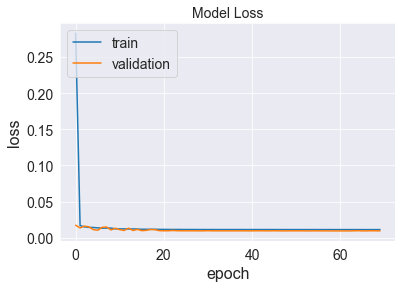

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_128 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_129 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_64 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_64 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_128 (TimeDi (None, 7, 32)           

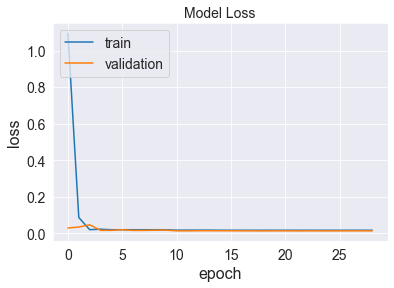

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_130 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_131 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_65 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_65 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_130 (TimeDi (None, 7, 32)           

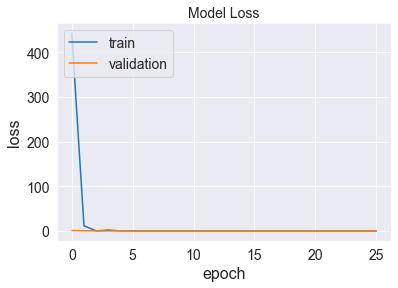

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_66 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_66 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_66 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_132 (TimeDi (None, 7, 32)           

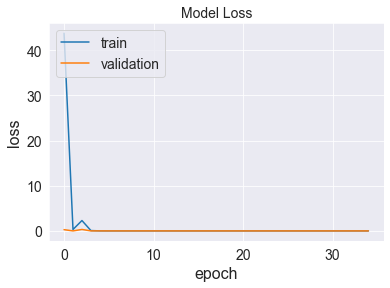

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_134 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_67 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_67 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_67 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_134 (TimeDi (None, 7, 32)           

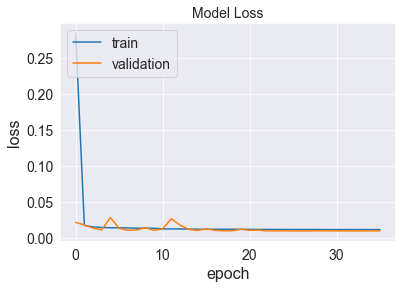

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_136 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_137 (Conv1D)          (None, 2, 128)            32896     
_________________________________________________________________
max_pooling1d_68 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
flatten_68 (Flatten)         (None, 256)               0         
_________________________________________________________________
repeat_vector_68 (RepeatVect (None, 7, 256)            0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 7, 64)             82176     
_________________________________________________________________
time_distributed_136 (TimeDi (None, 7, 32)           

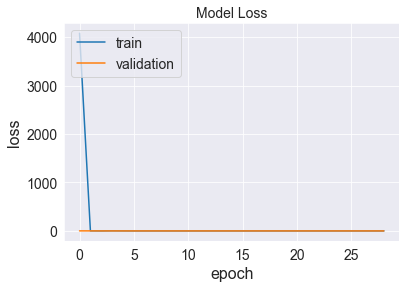

Number of finished trials: 69
Best trial:
  Value: 0.008945832960307598
  Params: 
    activation: selu
    filters: 128
    kernel_initializer: glorot_uniform
    kernel_regularizer: l2
    kernel_size: 2
    learning_rate: 0.001283663985520444
    lstm_units: 64
    optimizer: rmsprop
    pool_size: 1
    strides: 2
Study statistics: 
  Number of finished trials:  69
  Number of pruned trials:  0
  Number of complete trials:  69
Best trial:
  Value:  0.008945832960307598
  Params: 
    activation: selu
    filters: 128
    kernel_initializer: glorot_uniform
    kernel_regularizer: l2
    kernel_size: 2
    learning_rate: 0.001283663985520444
    lstm_units: 64
    optimizer: rmsprop
    pool_size: 1
    strides: 2


In [18]:
print("===============")
print("Preparing Data")
print("===============")
n_input = 8
train, test = split_dataset(scaled)
train_x, train_y = to_supervised(train, n_input)
test_x, test_y = to_supervised(test, n_input)
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# Reshape output into [samples, timesteps, features].
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
print("========================")
print("Tuning Model with Optuna")
print("========================")


#Add Pruner
objective = ExperimentManager(optuna_args_dict, hps_dict,train_x, train_y, test_x, test_y, callbacks_list )
study = optuna.create_study(study_name = 'HECSTUDY2' , direction=optuna_args_dict['direction'], 
                            storage='sqlite:///' + optuna_args_dict['name'] + '_Optuna.db') #optuna_args_dict['name']
study.optimize(objective, timeout=2*60*60) # Timeout in seconds e.g. timeout=20*60*60 
show_results(study)

In [ ]:
# Load study (add the below two lines in constructor, to load an existing study with corect name)
#optuna.load_study(study_name=study_name, storage='sqlite:///' + optuna_args_dict['name'] + '_Optuna.db')
#print(study.best_trial)

In [21]:
import joblib
joblib.dump(study, 'studies/enc_dec_CNN_LSTM_optuna.pkl')

['studies/enc_dec_CNN_LSTM_optuna.pkl']

In [22]:
study = joblib.load('studies/enc_dec_CNN_LSTM_optuna.pkl')
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete'], axis=1)
df.head()

number     value        duration params_activation  params_filters  \
0       0  0.010000 00:01:07.110156               elu             128   
1       1  0.013598 00:02:27.615261            linear             128   
2       2  0.013615 00:01:07.417493               elu              64   
3       3  0.013973 00:00:48.024546               elu              64   
4       4  0.013882 00:00:19.259093              selu              32   

  params_kernel_initializer params_kernel_regularizer  params_kernel_size  \
0            glorot_uniform                        l2                   2   
1            glorot_uniform                        l1                   2   
2             glorot_normal                        l2                   2   
3            glorot_uniform                        l2                   2   
4             glorot_normal                        l2                   2   

   params_learning_rate  params_lstm_units params_optimizer  params_pool_size  \
0              0.078041                 64              sgd                 1   
1              0.009713                 64             adam                 2   
2              0.080145                 32          rmsprop                 2   
3              0.047156                 32             adam                 1   
4              0.031140                 32          rmsprop                 2   

   params_strides  
0               2  
1               2  
2               1  
3               2  
4               2

### Add visualizations for parameter vs RMSE

In [30]:
df_trial = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df_trial

number     value params_activation  params_filters  \
0        0  0.010000               elu             128   
1        1  0.013598            linear             128   
2        2  0.013615               elu              64   
3        3  0.013973               elu              64   
4        4  0.013882              selu              32   
5        5  0.013589               elu              32   
6        6  0.013615              relu              32   
7        7  0.013603               elu              64   
8        8  0.013600               elu              32   
9        9  0.013473              selu              64   
10      10  0.009973            linear             128   
11      11  0.010056            linear             128   
12      12  0.010022            linear             128   
13      13  0.009996              relu             128   
14      14  0.009990              relu             128   
15      15  0.010009              relu             128   
16      16  0.010032              relu             128   
17      17  0.014897            linear             128   
18      18  0.010058            linear             128   
19      19  0.011551              relu             128   
20      20  0.012706              relu             128   
21      21  0.010053              relu             128   
22      22  0.009977              relu             128   
23      23  0.010005              relu             128   
24      24  0.009961              relu             128   
25      25  0.009976            linear             128   
26      26  0.013978            linear             128   
27      27  0.009985            linear             128   
28      28  0.010033            linear             128   
29      29  0.009690              selu             128   
30      30  0.009675              selu             128   
31      31  0.009721              selu             128   
32      32  0.009615              selu             128   
33      33  0.009655              selu             128   
34      34  0.013841              selu             128   
35      35  0.009741              selu              64   
36      36  0.013607              selu             128   
37      37  0.009796              selu              32   
38      38  0.013650              selu              64   
39      39  0.013602              selu              32   
40      40  0.009626              selu             128   
41      41  0.009637              selu             128   
42      42  0.009663              selu             128   
43      43  0.010200              selu             128   
44      44  0.013660              selu             128   
45      45  0.009803              selu             128   
46      46  0.013590              selu              64   
47      47  0.009694              selu             128   
48      48  0.010165               elu              32   
49      49  0.009041              selu             128   
50      50  0.009037              selu             128   
51      51  0.008963              selu             128   
52      52  0.009120              selu             128   
53      53  0.008974              selu             128   
54      54  0.013542              selu             128   
55      55  0.013567              selu             128   
56      56  0.009113              selu             128   
57      57  0.009361               elu             128   
58      58  0.013616              selu             128   
59      59  0.013605              selu             128   
60      60  0.009043              selu             128   
61      61  0.008946              selu             128   
62      62  0.013628              selu             128   
63      63  0.009055              selu             128   
64      64  0.013659              selu             128   
65      65  0.013613              selu             128   
66      66  0.013614              selu             128   
67      67  0.009001              selu             128   
68

In [33]:
trial_file = df_trial.to_csv('studies/enc_dec_CNNLSTM_trial.csv', index=False)
print("Best trial:")
best_trial = study.best_trial

print("  Value: {}".format(best_trial.value))

print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value: 0.008945832960307598
  Params: 
    activation: selu
    filters: 128
    kernel_initializer: glorot_uniform
    kernel_regularizer: l2
    kernel_size: 2
    learning_rate: 0.001283663985520444
    lstm_units: 64
    optimizer: rmsprop
    pool_size: 1
    strides: 2


In [36]:
import pandas_profiling
pandas_profiling.ProfileReport(df_trial)

### NOTE

We increase the timeout above to train more trial and get the best possible model

### Visualization of Optuna Trials

|Parameter Name |Description|
|--|-------------------------------|
| optuna.visualization.plot_contour  | Plot the parameter relationship as contour plot in a study. | 
| optuna.visualization.plot_edf  | Plot the objective value EDF (empirical distribution function) of a study. | 
| optuna.visualization.plot_intermediate_values  | Plot intermediate values of all trials in a study. | 
| optuna.visualization.plot_optimization_history |  Plot optimization history of all trials in a study. | 
| optuna.visualization.plot_parallel_coordinate |  Plot the high-dimentional parameter relationships in a study. | 
| optuna.visualization.plot_param_importances |  Plot hyperparameter importances. | 
| optuna.visualization.plot_slice |  Plot the parameter relationship as slice plot in a study. | 
| optuna.visualization.is_available | Returns whether visualization is available or not. | 

In [24]:
optuna.visualization.is_available()

True

In [25]:
optuna.visualization.plot_slice(study)

In [26]:
optuna.visualization.plot_optimization_history(study)

In [27]:
optuna.visualization.plot_parallel_coordinate(study) 

In [37]:
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

  Params: 
    activation: selu
    filters: 128
    kernel_initializer: glorot_uniform
    kernel_regularizer: l2
    kernel_size: 2
    learning_rate: 0.001283663985520444
    lstm_units: 64
    optimizer: rmsprop
    pool_size: 1
    strides: 2


### Defining the best model

In [46]:


def tuned_model():
    # Sequential Layer
    model = Sequential()
    # Covolutional Layer
    model.add(
        Conv1D(
                filters=128,
                kernel_size=2,
                strides=2,
                activation= 'selu',
                input_shape = (n_timesteps,n_features)
            )
    )
    model.add(
        Conv1D(
                filters=64,
                kernel_size=2,
                strides=1,
                activation='selu',
                input_shape = (n_timesteps,n_features)
            )
    )    
    # Pooling Layer
    model.add(MaxPooling1D(pool_size = 1))
    model.add(Dropout(0.3))
    # Flatter the layer to use fully conected layers
    model.add(Flatten())    
    model.add(RepeatVector(n_outputs))
        
        
    model.add(
        LSTM(
            units = 64,
            activation='relu', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(1, activation='linear')))
    # Compile model with a sampled learning rate.
    opt = Adam(learning_rate = 0.001)
    
    model.compile(
        loss="mse", optimizer=opt, metrics=[optuna_args_dict['metric']]
    )

    print(model.summary())

    return model

In [47]:
best_moddel = tuned_model()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_142 (Conv1D)          (None, 4, 128)            384       
_________________________________________________________________
conv1d_143 (Conv1D)          (None, 3, 64)             16448     
_________________________________________________________________
max_pooling1d_71 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 3, 64)             0         
_________________________________________________________________
flatten_71 (Flatten)         (None, 192)               0         
_________________________________________________________________
repeat_vector_71 (RepeatVect (None, 7, 192)            0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 7, 64)           

### Prepare data.

CNN-LSTM Encoder-Decoder model
Train on 988 samples, validate on 110 samples
Epoch 1/100
988/988 - 4s - loss: 0.0267 - mean_squared_error: 0.0267 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 2/100
988/988 - 2s - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0083 - val_mean_squared_error: 0.0083
Epoch 3/100
988/988 - 2s - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 4/100
988/988 - 2s - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0092 - val_mean_squared_error: 0.0092
Epoch 5/100
988/988 - 2s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 6/100
988/988 - 2s - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 7/100
988/988 - 2s - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 8/100
988/988 - 2s - loss: 0.0128 - mean_squared_error: 0.0128 - val_l

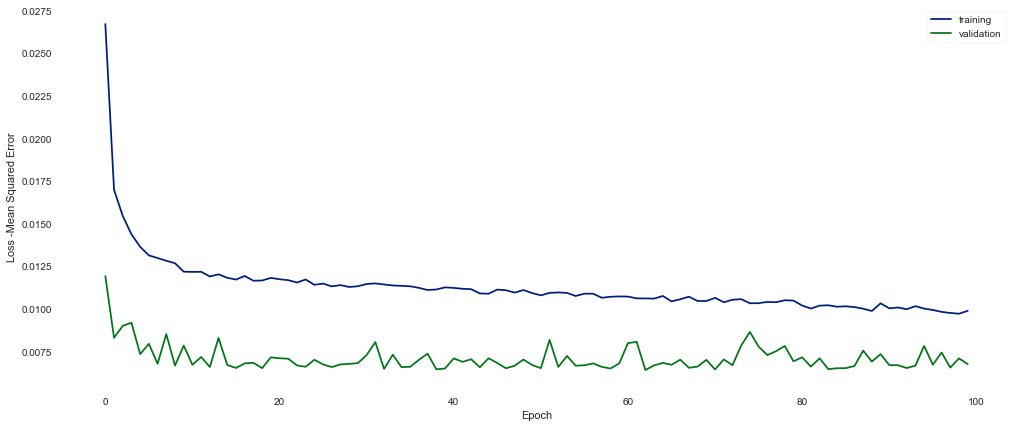

Mean Test RMSE Score :  0.09094
RMSE for each Weekday


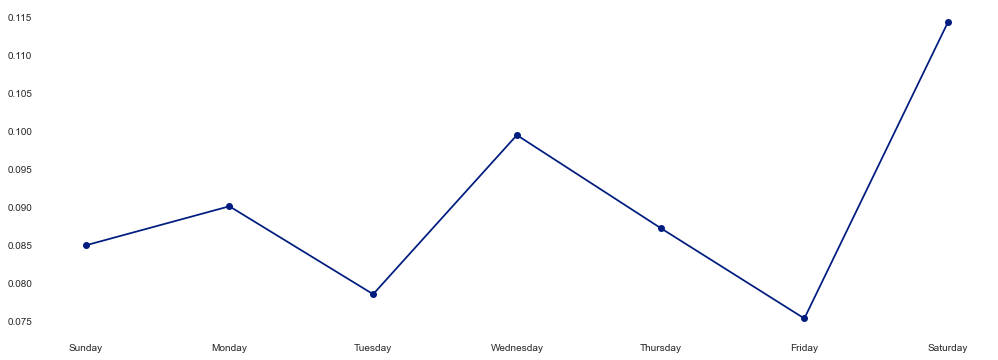

In [48]:
train_x, train_y = to_supervised(train, n_input)
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
# Reshape output into [samples, timesteps, features].
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))

print("CNN-LSTM Encoder-Decoder model")
print("==============================")


history = best_moddel.fit(train_x, train_y, epochs=100, validation_split = 0.1, batch_size=8, verbose=2,)

learning_curve(history)

scores = evaluate_model(best_moddel, forecast, train, test, 8)
get_mean_rmse_and_plot_rmse(scores, days)

The best tune model of our "CNN-LSTM Encoder-Decoder model" achieved an improved RMSE OF 0.09094.